In [92]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import json
import numpy as np

In [39]:
# set up metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score

def plot_conf_mat(conf_matrix):
    plt.close()
    plt.clf()
    plt.rcParams["figure.autolayout"] = False
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=12)
    plt.ylabel('Actuals', fontsize=12)
    plt.title('Confusion Matrix', fontsize=12)
    plt.show()

def plot_roc(roc_auc):
    plt.close()
    plt.clf()        
    plt.rcParams["figure.autolayout"] = False
    plt.figure(figsize=(3, 3))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Great Wine ROC')
    plt.legend(loc="lower right")
    plt.show()


In [52]:
df = pd.read_csv('/home/max/code/msds-supervised-learning-final/data/winequality-white.csv', sep=';')

# remove spaces from column names
df = df.rename(columns={
    'fixed acidity': 'fixed_acidity', 'volatile acidity':'volatile_acidity',
    'citric acid': 'citric_acid', 'residual sugar': 'residual_sugar',
    'free sulfur dioxide': 'free_sulfur_dioxide', 'total sulfur dioxide': 'total_sulfur_dioxide'
})

# thankfully, no NA/missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         4898 non-null   float64
 1   volatile_acidity      4898 non-null   float64
 2   citric_acid           4898 non-null   float64
 3   residual_sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free_sulfur_dioxide   4898 non-null   float64
 6   total_sulfur_dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [53]:
# adding 'is_great' column, and dropping 'quality'
df['is_great'] = np.where(df['quality'] >= 7, 1, 0)
df = df.drop(['quality'], axis=1)
print(df['is_great'].value_counts())
df.describe()

0    3838
1    1060
Name: is_great, dtype: int64


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,is_great
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,0.216415
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.411842
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,0.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,0.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,0.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,1.000000


In [88]:
# handle is_great class imbalance
ok_count, great_count = df['is_great'].value_counts()

great = df[df['is_great'] == 1]
ok = df[df['is_great'] == 0]
ok_smaller = ok.sample(great_count)

# new dataset
balanced_data = pd.concat([ok_smaller, great], axis=0)
print(balanced_data['is_great'].value_counts())
balanced_data.describe()

0    1060
1    1060
Name: is_great, dtype: int64


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,is_great
count,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000
mean,6.798939,0.275408,0.328646,6.070024,0.043582,35.031368,134.152358,0.993484,3.199019,0.495566,10.843937,0.500000
std,0.804695,0.099162,0.107118,4.977527,0.022130,15.513116,40.006932,0.003126,0.152785,0.122781,1.313005,0.500118
min,3.900000,0.080000,0.000000,0.700000,0.012000,3.000000,10.000000,0.987110,2.770000,0.220000,8.400000,0.000000
25%,6.300000,0.210000,0.270000,1.800000,0.034000,24.000000,106.000000,0.991100,3.090000,0.410000,9.700000,0.000000
50%,6.800000,0.260000,0.310000,4.700000,0.040000,34.000000,129.000000,0.993000,3.190000,0.480000,10.800000,0.500000
75%,7.300000,0.320000,0.370000,9.100000,0.048000,44.500000,159.000000,0.995500,3.300000,0.560000,11.940000,1.000000
max,9.900000,1.100000,1.000000,65.800000,0.346000,146.500000,366.500000,1.038980,3.820000,1.080000,14.200000,1.000000


In [86]:
# now rescale the features
# note: this splits out independent from dependent var
features, labels =  balanced_data.drop(["is_great"],axis=1), balanced_data["is_great"]

scaler = preprocessing.MinMaxScaler()
names = features.columns
d = scaler.fit_transform(features)

balanced_scaled_data = pd.DataFrame(d, columns=names)
balanced_scaled_data.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000
mean,0.288396,0.262299,0.329698,0.175189,0.111994,0.226675,0.410641,0.275485,0.387051,0.317321,0.417364
std,0.079145,0.131426,0.106555,0.159146,0.067449,0.113197,0.129640,0.131185,0.148619,0.142718,0.229195
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.240385,0.163265,0.270000,0.032362,0.079137,0.153310,0.315789,0.172057,0.284314,0.209302,0.206897
50%,0.288462,0.244898,0.310000,0.129450,0.100719,0.216028,0.394737,0.253989,0.372549,0.290698,0.413793
75%,0.336538,0.326531,0.380000,0.275081,0.133094,0.292683,0.493421,0.369448,0.490196,0.395349,0.603448
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [63]:
# iterate through several models to try
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

def run_classification(train_X, train_y, test_X, test_y):
    models = [
        ('rf', RandomForestClassifier()), 
        ('knn', KNeighborsClassifier()), 
        ('svc', SVC()), 
        ('perceptron', Perceptron()),
        ('adaboost', AdaBoostClassifier()),
        ('gradboost', GradientBoostingClassifier()),
        ('bagg', BaggingClassifier())
    ]

    results = []

    best = ['',0]

    for n,clf in models:
        clf.fit(train_X, train_y)
        yhat = clf.predict(test_X)

        fpr, tpr, thresholds = roc_curve(test_y, yhat)
        roc_auc = auc(fpr, tpr)

        prec = precision_score(test_y, yhat)
        rec = recall_score(test_y, yhat)
        acc = accuracy_score(test_y, yhat)
        mcc = matthews_corrcoef(test_y, yhat)
        f1 = f1_score(test_y, yhat)

        # chosen metric to find 'best' classifier
        met = roc_auc

        results.append({
            'classifier': n, 
            'precision': prec,
            'recall': rec,
            'accuracy': acc,
            'mcc': mcc,
            'f1': f1,
            'roc_auc': roc_auc
        })

        if met > best[1]:
            best = [clf, met]
    
    return best, results


In [91]:
# using data as is, without feature scaling or resampling 
train_X, test_X, train_y, test_y = train_test_split(df.drop(["is_great"],axis=1), df["is_great"], train_size=0.8)

best, results = run_classification(train_X, train_y, test_X, test_y)
print('best:', best)
print(json.dumps(results, indent=4, sort_keys=True))

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


best: [RandomForestClassifier(), 0.7902564102564102]
[
    {
        "accuracy": 0.8969387755102041,
        "classifier": "rf",
        "f1": 0.7072463768115942,
        "mcc": 0.6589415237023905,
        "precision": 0.8413793103448276,
        "recall": 0.61,
        "roc_auc": 0.7902564102564102
    },
    {
        "accuracy": 0.7938775510204081,
        "classifier": "knn",
        "f1": 0.42937853107344626,
        "mcc": 0.31007728049106315,
        "precision": 0.4935064935064935,
        "recall": 0.38,
        "roc_auc": 0.64
    },
    {
        "accuracy": 0.7959183673469388,
        "classifier": "svc",
        "f1": 0.0,
        "mcc": 0.0,
        "precision": 0.0,
        "recall": 0.0,
        "roc_auc": 0.5
    },
    {
        "accuracy": 0.7908163265306123,
        "classifier": "perceptron",
        "f1": 0.00966183574879227,
        "mcc": -0.012884914797171996,
        "precision": 0.14285714285714285,
        "recall": 0.005,
        "roc_auc": 0.49865384615384

In [104]:
# oversampling and feature scaling

from sklearn import preprocessing
from imblearn.over_sampling import SMOTE 
oversample = SMOTE()

features, labels =  oversample.fit_resample(df.drop(["is_great"],axis=1), df["is_great"])

scaler = preprocessing.MinMaxScaler()
names = features.columns
d = scaler.fit_transform(features)

scaled_df = pd.DataFrame(d, columns=names)
scaled_df.describe()


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000
mean,0.289250,0.190076,0.199279,0.082741,0.100912,0.115511,0.289557,0.122261,0.434482,0.317950,0.457266
std,0.074972,0.092726,0.062875,0.074014,0.055671,0.054976,0.091804,0.057453,0.133483,0.131013,0.205974
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.240385,0.127451,0.167777,0.018405,0.074184,0.076655,0.224498,0.077553,0.345455,0.221113,0.274194
50%,0.288134,0.176471,0.190813,0.061350,0.091988,0.111498,0.278422,0.111240,0.427273,0.302326,0.461538
75%,0.335154,0.235294,0.222892,0.128834,0.115727,0.149729,0.348028,0.161751,0.520903,0.386473,0.629032
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [72]:
scaled_oversampled_train_X, scaled_oversampled_test_X, scaled_oversampled_train_y, scaled_oversampled_test_y = train_test_split(scaled_df, labels, train_size=0.8)

scaled_oversampled_best, scaled_oversampled_results = run_classification(scaled_oversampled_train_X, scaled_oversampled_train_y, scaled_oversampled_test_X, scaled_oversampled_test_y)
print('best:',scaled_oversampled_best)
print(json.dumps(scaled_oversampled_results, indent=4, sort_keys=True))

best: [RandomForestClassifier(), 0.9137435410108689]
[
    {
        "accuracy": 0.9134114583333334,
        "classifier": "rf",
        "f1": 0.9119788219722039,
        "mcc": 0.8271187260546384,
        "precision": 0.8994778067885117,
        "recall": 0.9248322147651007,
        "roc_auc": 0.9137435410108689
    },
    {
        "accuracy": 0.8216145833333334,
        "classifier": "knn",
        "f1": 0.8327228327228328,
        "mcc": 0.6571571148293556,
        "precision": 0.7637178051511758,
        "recall": 0.9154362416107382,
        "roc_auc": 0.8243426467219304
    },
    {
        "accuracy": 0.7981770833333334,
        "classifier": "svc",
        "f1": 0.8072139303482586,
        "mcc": 0.6049741818987697,
        "precision": 0.7520278099652375,
        "recall": 0.8711409395973154,
        "roc_auc": 0.8002986619604783
    },
    {
        "accuracy": 0.7356770833333334,
        "classifier": "perceptron",
        "f1": 0.7360208062418726,
        "mcc": 0.472791547

In [80]:
# test the oversampled/scaled best classifier on non-modified balanced data
features, labels =  balanced_data.drop(["is_great"],axis=1), balanced_data["is_great"]

scaler = preprocessing.MinMaxScaler()
names = features.columns
d = scaler.fit_transform(features)

scaled_df = pd.DataFrame(d, columns=names)
scaled_df.describe()


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000
mean,0.288396,0.262299,0.329698,0.175189,0.111994,0.226675,0.410641,0.275485,0.387051,0.317321,0.417364
std,0.079145,0.131426,0.106555,0.159146,0.067449,0.113197,0.129640,0.131185,0.148619,0.142718,0.229195
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.240385,0.163265,0.270000,0.032362,0.079137,0.153310,0.315789,0.172057,0.284314,0.209302,0.206897
50%,0.288462,0.244898,0.310000,0.129450,0.100719,0.216028,0.394737,0.253989,0.372549,0.290698,0.413793
75%,0.336538,0.326531,0.380000,0.275081,0.133094,0.292683,0.493421,0.369448,0.490196,0.395349,0.603448
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [81]:
scaled_train_X, scaled_test_X, scaled_train_y, scaled_test_y = train_test_split(scaled_df,labels,train_size=0.8)

scaled_best, scaled_results = run_classification(scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y)

print('best:',scaled_best)
print(json.dumps(scaled_results, indent=4, sort_keys=True))


best: [RandomForestClassifier(), 0.8240895422652856]
[
    {
        "accuracy": 0.8231132075471698,
        "classifier": "rf",
        "f1": 0.8235294117647058,
        "mcc": 0.6482873941786714,
        "precision": 0.7954545454545454,
        "recall": 0.8536585365853658,
        "roc_auc": 0.8240895422652856
    },
    {
        "accuracy": 0.7523584905660378,
        "classifier": "knn",
        "f1": 0.7651006711409397,
        "mcc": 0.5148483361432048,
        "precision": 0.7066115702479339,
        "recall": 0.8341463414634146,
        "roc_auc": 0.7549727141107027
    },
    {
        "accuracy": 0.7877358490566038,
        "classifier": "svc",
        "f1": 0.7954545454545454,
        "mcc": 0.5828098954830325,
        "precision": 0.7446808510638298,
        "recall": 0.8536585365853658,
        "roc_auc": 0.7898429669228199
    },
    {
        "accuracy": 0.6462264150943396,
        "classifier": "perceptron",
        "f1": 0.7093023255813953,
        "mcc": 0.348356193

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       216
           1       0.96      0.96      0.96       208

    accuracy                           0.96       424
   macro avg       0.96      0.96      0.96       424
weighted avg       0.96      0.96      0.96       424



<Figure size 640x480 with 0 Axes>

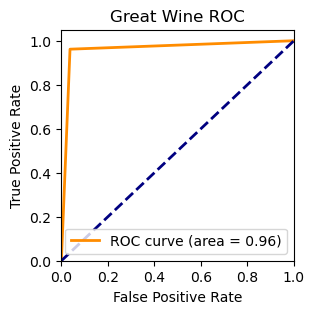

<Figure size 640x480 with 0 Axes>

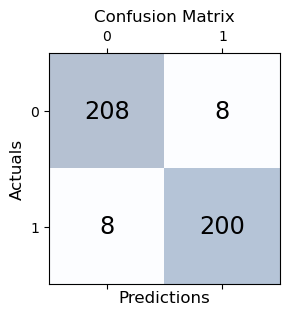

In [84]:
# final test on scaled data without oversampling
train_X, test_X, train_y, test_y = train_test_split(scaled_df,labels,train_size=0.8)


#clf = scaled_oversampled_best[0]
clf = scaled_best[0]

yhat = clf.predict(test_X)

# metrics
print(classification_report(test_y, yhat))

# roc
fpr, tpr, thresholds = roc_curve(test_y, yhat)
roc_auc = auc(fpr, tpr)
plot_roc(roc_auc)

# confusion matrix
conf_matrix = confusion_matrix(test_y, yhat)
plot_conf_mat(conf_matrix)

In [97]:
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def plotSearchGrid(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid["C"]), len(grid.param_grid["gamma"]))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid["gamma"])), grid.param_grid["gamma"], rotation=45)
    plt.yticks(np.arange(len(grid.param_grid["C"])), grid.param_grid["C"])
    plt.title('Validation accuracy')
    plt.show()

In [105]:
# SVM gridsearch
from sklearn.model_selection import cross_val_score, GridSearchCV

train_X, test_X, train_y, test_y = train_test_split(scaled_df, labels, train_size=0.8)

parameters = {
    'gamma':[2**-5, 2**-4, 2**-3, 2**-2, 2**-1, 2**0, 2**1, 2**2, 2**3, 2**4, 2**5],
    'C':[2**-5, 2**-4, 2**-3, 2**-2, 2**-1, 2**0, 2**1, 2**2, 2**3, 2**4, 2**5]
}

svc = SVC()
grid = GridSearchCV(svc, parameters, cv=3)
grid.fit(train_X, train_y)


GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8,
                               16, 32],
                         'gamma': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4,
                                   8, 16, 32]})

In [106]:
print(grid.best_params_)
print(grid.best_score_)

{'C': 16, 'gamma': 32}
0.8770343649553194


              precision    recall  f1-score   support

           0       0.94      0.86      0.90       772
           1       0.87      0.94      0.91       764

    accuracy                           0.90      1536
   macro avg       0.91      0.90      0.90      1536
weighted avg       0.91      0.90      0.90      1536



<Figure size 640x480 with 0 Axes>

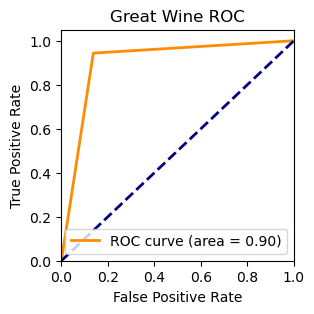

<Figure size 640x480 with 0 Axes>

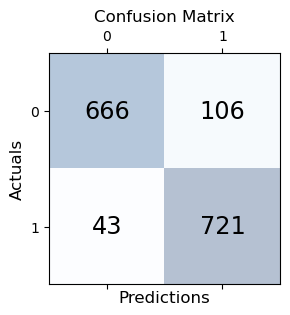

In [107]:
yhat = grid.predict(test_X)

# metrics
print(classification_report(test_y, yhat))

# roc
fpr, tpr, thresholds = roc_curve(test_y, yhat)
roc_auc = auc(fpr, tpr)
plot_roc(roc_auc)

# confusion matrix
conf_matrix = confusion_matrix(test_y, yhat)
plot_conf_mat(conf_matrix)

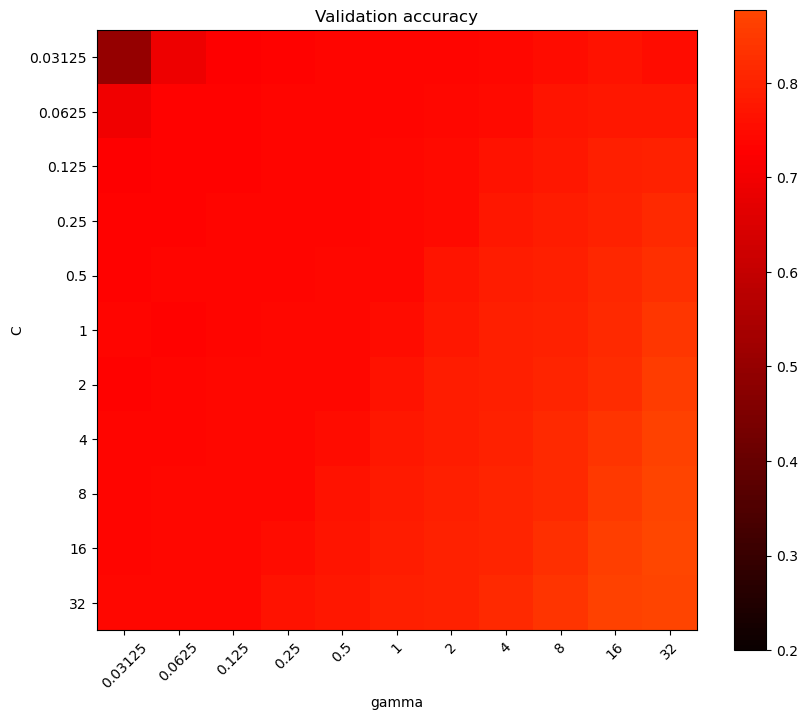

In [108]:
plotSearchGrid(grid)